# Кредитный скоринг
При принятии решения о выдаче кредита или займа учитывается т.н. «Кредитный скоринг» — рейтинг платежеспособности клиента. ИИ на основе модели, которую просчитывает машинное обучение — в ней много параметров — возраст, зарплата, кредитная история, наличие недвижимости, автомобиля, судимости и других признаков, после обработки которых выносится положительное или отрицательное решение

In [157]:
# Импортируем библиотеки
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

!pip install pyspark

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import OneHotEncoder, MinMaxScaler
from pyspark.sql import SparkSession, functions as f


spark = SparkSession.builder\
    .master("local[2]")\
    .appName("Lesson_2")\
    .config("spark.executor.instances",2)\
    .config("spark.executor.memory",'2g')\
    .config("spark.executor.cores",1)\
    .getOrCreate()
sc = spark.sparkContext

# Данные:
[скачать](https://drive.google.com/file/d/1MuAyZiIm3b_r-AgQSj78tsRPqZpvv_2s/view?usp=sharing)

**application_record.csv**
*   Feature name	Explanation	Remarks
*   ID	Client number	
*   CODE_GENDER	Gender	
*   FLAG_OWN_CAR	Is there a car	
*   FLAG_OWN_REALTY	Is there a property	
*   CNT_CHILDREN	Number of children	
*   AMT_INCOME_TOTAL	Annual income	
*   NAME_INCOME_TYPE	Income category	
*   NAME_EDUCATION_TYPE	Education level	
*   NAME_FAMILY_STATUS	Marital status	
*   NAME_HOUSING_TYPE	Way of living	
*   DAYS_BIRTH	Birthday	Count backwards from current day (0), -1 means yesterday
*   DAYS_EMPLOYED	Start date of employment	Count backwards from current day(0). If positive, it means the person currently unemployed.
FLAG_MOBIL	Is there a mobile phone	
*   FLAG_WORK_PHONE	Is there a work phone	
*   FLAG_PHONE	Is there a phone	
*   FLAG_EMAIL	Is there an email	
*   OCCUPATION_TYPE	Occupation	
*   CNT_FAM_MEMBERS	Family size	

**credit_record.csv**
*   Feature name	Explanation	Remarks
*   ID	Client number	
*   MONTHS_BALANCE	Record month	The month of the extracted data is the starting point, backwards, 0 is the current month, -1 is the previous month, and so on
*   STATUS	Status	
   *   0: 1-29 days past due
   *   1: 30-59 days past due 
   *   2: 60-89 days overdue 
   *   3: 90-119 days overdue 
   *   4: 120-149 days overdue 
    *   5: Overdue or bad debts, write-offs for more than 150 days
    *   C: paid off that month X: No loan for the month


## Считываем данные

In [158]:
data = spark.read.csv('application_record.csv', header=True)
record = spark.read.csv('credit_record.csv', header=True)

In [191]:
new_data = data.join(record.groupBy('ID').agg((f.min('MONTHS_BALANCE')*-1).alias('BEGIN_MONTH')), how='left', on='ID')

def default(status):
    try:
      if int(status) >= 2:
        return 'Yes'
      else:
        return 'No'
    except:
      return 'No'

func_udf = f.udf(default)
cpunt = record.withColumn(
    'dep_value', 
    func_udf(record['STATUS'])
    ).groupBy('ID').agg(
    f.count('dep_value').alias('dep_count')
    ).withColumn(
    'dep_value', 
    f.when(
        f.col('dep_count')>0, 
        'Yes'
        ).otherwise('No')
        )
new_data = new_data.join(
    cpunt, 
    how='left', 
    on='ID'
    ).withColumn(
        'target', 
        f.when(f.col('dep_value')=='Yes', 1).otherwise(0)
        )

new_data.show(5)

+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+-----------+---------+---------+------+
|     ID|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|    NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|  NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|FLAG_MOBIL|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|OCCUPATION_TYPE|CNT_FAM_MEMBERS|BEGIN_MONTH|dep_count|dep_value|target|
+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+-----------+---------+---------+------+
|5008804|          M|           Y|              Y|           0|        427500.0

In [192]:
# Упростим себе задачу и оставим толкь часть признаков
from pyspark.sql.types import FloatType, IntegerType
features = ['AMT_INCOME_TOTAL', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN']	
target = ['target']
dataset = new_data.select(features + target)
dataset = dataset.withColumn("AMT_INCOME_TOTAL", dataset["AMT_INCOME_TOTAL"].cast(FloatType()))
dataset = dataset.withColumn("CNT_CHILDREN", dataset["CNT_CHILDREN"].cast(IntegerType()))
dataset.show(5)

+----------------+-----------+------------+---------------+------------+------+
|AMT_INCOME_TOTAL|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|target|
+----------------+-----------+------------+---------------+------------+------+
|        427500.0|          M|           Y|              Y|           0|     1|
|        427500.0|          M|           Y|              Y|           0|     1|
|        112500.0|          M|           Y|              Y|           0|     1|
|        270000.0|          F|           N|              Y|           0|     1|
|        270000.0|          F|           N|              Y|           0|     1|
+----------------+-----------+------------+---------------+------------+------+
only showing top 5 rows



In [193]:
dataset.select('target').distinct().show()

+------+
|target|
+------+
|     1|
|     0|
+------+



У нас есть выборка, где указаны параметры клиента, и вышел ли он на просрочку или нет.

Дальше будем исследовать, есть ли связь между этими параметрами и возвратом кредита.

Можете уже на этом этапе предложить гипотезы, а мы их проверим. Предположим, что чем больше детей, тем меньше вероятность, что будет просрочка.

In [194]:
# Разделим выборку на трейн и тест, на трейн будем обучать модель, на тест валидировать.
data_train, data_test = dataset.randomSplit([0.7, 0.3], seed=42)

In [197]:
# Давайте так же глянем корреляции (у численных)
# И мы наблюдаем, что корреляции почти нет
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

def correlation_matrix(df, corr_columns, method='pearson'):
    vector_col = "corr_features"
    assembler = VectorAssembler(inputCols=corr_columns, outputCol=vector_col)
    df_vector = assembler.transform(df).select(vector_col)
    matrix = Correlation.corr(df_vector, vector_col, method)

    result = matrix.collect()[0]["pearson({})".format(vector_col)].values
    return pd.DataFrame(result.reshape(-1, len(corr_columns)), columns=corr_columns, index=corr_columns)

num_cols = [item[0] for item in data_train.dtypes if not item[1].startswith('string')] 
cat_cols = [item[0] for item in data_train.dtypes if item[1].startswith('string')]

correlation_matrix(data_train, num_cols)

,AMT_INCOME_TOTAL,CNT_CHILDREN,target
AMT_INCOME_TOTAL,1.000000,0.017319,-0.003738
CNT_CHILDREN,0.017319,1.000000,0.000043
target,-0.003738,0.000043,1.000000


In [198]:
num_cols = list(set(num_cols) - set(['target']))

In [216]:
# Превращаем категориальные факторы в численные
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorIndexer, VectorAssembler

indexers = [
    StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
    for c in cat_cols
]

# The encode of indexed vlaues multiple columns
encoders = [OneHotEncoder(dropLast=False,inputCol=indexer.getOutputCol(),
            outputCol="{0}_encoded".format(indexer.getOutputCol())) 
    for indexer in indexers
]

assembler1 = [VectorAssembler(inputCols=[c], outputCol=f"{c}_vec") for c in num_cols]

scalers = [
           MinMaxScaler(
               inputCol=ass.getOutputCol(), 
               outputCol=ass.getOutputCol() + "_scaled"
               ) for ass in assembler1
           ]
in_cols = [encoder.getOutputCol() for encoder in encoders]+\
    [scaler.getOutputCol() for scaler in scalers]
assembler2 = [VectorAssembler(
    inputCols=in_cols,
    outputCol="transformed_features"
)]

stages = indexers + encoders + assembler1 + scalers + assembler2
pipeline = Pipeline(stages=stages).fit(dataset)
data_train_tr = pipeline.transform(data_train)
data_test_tr = pipeline.transform(data_test)

In [217]:
data_train_tr.show(5)

+----------------+-----------+------------+---------------+------------+------+-------------------+--------------------+-----------------------+---------------------------+----------------------------+-------------------------------+--------------------+----------------+---------------------------+-----------------------+--------------------+
|AMT_INCOME_TOTAL|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|target|CODE_GENDER_indexed|FLAG_OWN_CAR_indexed|FLAG_OWN_REALTY_indexed|CODE_GENDER_indexed_encoded|FLAG_OWN_CAR_indexed_encoded|FLAG_OWN_REALTY_indexed_encoded|AMT_INCOME_TOTAL_vec|CNT_CHILDREN_vec|AMT_INCOME_TOTAL_vec_scaled|CNT_CHILDREN_vec_scaled|transformed_features|
+----------------+-----------+------------+---------------+------------+------+-------------------+--------------------+-----------------------+---------------------------+----------------------------+-------------------------------+--------------------+----------------+---------------------------+-----------

#  Модель

Модель будет находить коэффициенты alpha и beta, где Х наши колонки/факторы. Погуглите подробнее, но данная формула даёт вероятность события.

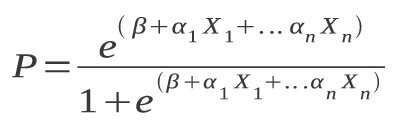

In [218]:
# Создадим простейшую модель, которая покажет через линейные коэффиценты связь переменных и таргета
model = LogisticRegression(featuresCol='transformed_features', labelCol='target')
model = model.fit(data_train_tr)

In [224]:
pred_train = model.transform(data_train_tr)
pred_test = model.transform(data_test_tr)

In [225]:
acc_train = pred_train.filter(pred_train.target == pred_train.prediction).count() / float(pred_train.count())
acc_test = pred_test.filter(pred_test.target == pred_test.prediction).count() / float(pred_test.count())
print(f'Точность (accuracy) модели на трейне {acc_train}, '
      f'на тесте {acc_test}')

Точность (accuracy) модели на трейне 0.9168635553368507, на тесте 0.9168868640850417


In [226]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
eval = BinaryClassificationEvaluator(labelCol='target')
print(f'ROC_AUC модели на трейне {eval.evaluate(pred_train)}, '
      f'на тесте {eval.evaluate(pred_test)}')

ROC_AUC модели на трейне 0.5148342987517035, на тесте 0.5145664050204845


In [227]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
eval = BinaryClassificationEvaluator(labelCol='target', metricName='areaUnderPR')
print(f'areaUnderPR модели на трейне {eval.evaluate(pred_train)}, '
      f'на тесте {eval.evaluate(pred_test)}')

areaUnderPR модели на трейне 0.08844774840384677, на тесте 0.087170882536079


In [228]:
coef = model.coefficients.toArray()

In [270]:
from itertools import chain

attrs = sorted(
    (attr["idx"], attr["name"]) for attr in (chain(*data_train_tr\
        .schema['transformed_features']\
        .metadata["ml_attr"]["attrs"].values())))
coef_map = [(name, coef[idx]) for idx, name in attrs]

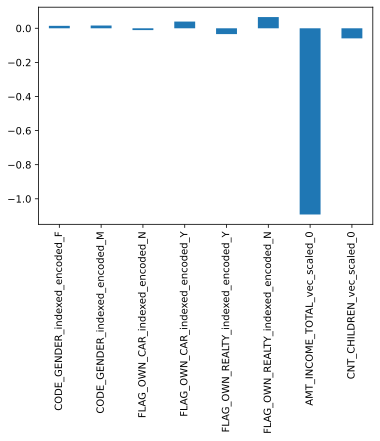

In [271]:
pd.Series([i[1] for i in coef_map],
    [i[0] for i in coef_map]
    ).plot.bar()
    

Из графика выше видно, какая переменная и с каокй силой влияет на скор.

Сильнее всего на просрочку влияет уровень, дохода. Отсутствие машины или жилья снижает рейтинг.

Наша гипотеза оказалась верной, но уровень дохода на кредитный скоринг влияет в три раза сильнее